In [ ]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Add, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

# CIFAR-10 데이터셋 불러오기
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
# 이미지 데이터 전처리 (정규화)
#255로 나누는 이유는 정규화
#픽셀값은 0~255값을 가지므로 255로 나누어 0~1의 값을 가지게함  // 정규화과정

x_train = x_train / 255.
x_test = x_test / 255.

x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))


In [ ]:
# 레이블 데이터를 One-hot Encoding으로 변환
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [ ]:
# conv_block

def conv(inputs, filters, kernel_size, strides, name):
    # Convolution layer
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same', name=name+'_conv')(inputs)
    # Batch normalization
    x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
    # ReLU activation
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    
    return x

In [ ]:
# identity_block
# use skip connection // shortcut
# 입력과 출력의 feature map의 크기와 채널 수가 동일

def identity(inputs, filters, kernel_size, name):
    # Shortcut connection
    shortcut = inputs
    # First conv block
    x = conv(inputs, filters, kernel_size, strides=1, name=name+'_conv1')
    # Second conv block
    x = conv(x, filters, kernel_size, strides=1, name=name+'_conv2')
    # Add shortcut and residual
    x = tf.keras.layers.add([shortcut, x], name=name+'_add')
    # ReLU activation
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    
    return x

In [ ]:
# projection_block
# use skip connection // shortcut
# 입력과 출력의 feature map의 크기와 채널 수가 다를 경우 사용

def projection(inputs, filters, kernel_size, strides, name):
    # Shortcut connection

    # 1*1컨볼루션 사용 중 // 입력값을 1x1 컨볼루션을 이용하여 출력값과 같은 채널 수로 변환한 후
    shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same', name=name+'_conv')(inputs)
    # First conv block
    x = conv(inputs, filters, kernel_size, strides=strides, name=name+'_conv1')
    # Second conv block
    x = conv(x, filters, kernel_size, strides=1, name=name+'_conv2')
    # Add shortcut and residual
    x = tf.keras.layers.add([shortcut, x], name=name+'_add')
    # ReLU activation
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    
    return x

In [ ]:
# ResNet

def resnet50(input_shape, num_classes):
    # Input layer
    inputs = tf.keras.layers.Input(shape=input_shape, name='input')
    # Initial convolution layer
    x = conv(inputs, filters=64, kernel_size=7, strides=2, name='conv1')
    # Max pooling layer
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='max_pool')(x)

    # Residual blocks
    x = projection(x, filters=64, kernel_size=3, strides=1, name='conv2_block1')
    x = identity(x, filters=64, kernel_size=3, name='conv2_block2')
    x = identity(x, filters=64, kernel_size=3, name='conv2_block3')

    x = projection(x, filters=128, kernel_size=3, strides=2, name='conv3_block1')
    x = identity(x, filters=128, kernel_size=3, name='conv3_block2')
    x = identity(x, filters=128, kernel_size=3, name='conv3_block3')
    x = identity(x, filters=128, kernel_size=3, name='conv3_block4')

    x = projection(x, filters=256, kernel_size=3, strides=2, name='conv4_block1')
    x = identity(x, filters=256, kernel_size=3, name='conv4_block2')
    x = identity(x, filters=256, kernel_size=3, name='conv4_block3')
    x = identity(x, filters=256, kernel_size=3, name='conv4_block4')
    x = identity(x, filters=256, kernel_size=3, name='conv4_block5')
    x = identity(x, filters=256, kernel_size=3, name='conv4_block6')

    x = projection(x, filters=512, kernel_size=3, strides=2, name='conv5_block1')
    x = identity(x, filters=512, kernel_size=3, name='conv5_block2')
    x = identity(x, filters=512, kernel_size=3, name='conv5_block3')

    # Average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    
    # Fully connected layer
    x = tf.keras.layers.Dense(units=256, activation='relu', name='fc')(x)
    x = tf.keras.layers.Dense(units=num_classes, activation='softmax', name='fc1')(x)  

    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=x, name='resnet50')
    
    return model

In [ ]:
resnet = resnet50(input_shape=(32, 32, 3), num_classes=10)

In [ ]:
# 모델 구조 확인하기
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['input[0][0]']                  
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                                  
 conv1_relu (ReLU)              (None, 16, 16, 64)   0           ['conv1_bn[0][0]']               
                                                                                           

In [ ]:
# 새로운 모델 생성하기
model = keras.models.Sequential()

# ResNet50 모델 추가하기
model.add(resnet)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab import drive

drive.mount('/content/gdrive')

filepath = '/content/gdrive/My Drive/project/newepoch/model.{epoch:02d}.hdf5'
modelckpt = ModelCheckpoint(filepath=filepath)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test),callbacks=[modelckpt])

Epoch 1/100
391/391 [==============================] - 47s 55ms/step - loss: 0.9564 - accuracy: 0.6688 - val_loss: 1.5819 - val_accuracy: 0.5165
Epoch 2/100
391/391 [==============================] - 20s 52ms/step - loss: 0.7988 - accuracy: 0.7233 - val_loss: 1.3889 - val_accuracy: 0.5582
Epoch 3/100
391/391 [==============================] - 20s 51ms/step - loss: 0.6784 - accuracy: 0.7636 - val_loss: 0.8787 - val_accuracy: 0.7006
Epoch 4/100
391/391 [==============================] - 20s 51ms/step - loss: 0.5884 - accuracy: 0.7966 - val_loss: 1.2946 - val_accuracy: 0.5917
Epoch 5/100
391/391 [==============================] - 20s 50ms/step - loss: 0.5057 - accuracy: 0.8263 - val_loss: 1.1347 - val_accuracy: 0.6632
Epoch 6/100
391/391 [==============================] - 20s 50ms/step - loss: 0.4451 - accuracy: 0.8446 - val_loss: 1.0676 - val_accuracy: 0.6768
Epoch 7/100
391/391 [==============================] - 20s 50ms/step - loss: 0.3740 - accuracy: 0.8707 - val_loss: 0.9719 - val_ac

In [ ]:
#저장
model.save('/content/gdrive/My Drive/project/finish/new/modelss.hdf5')

In [ ]:
# 모델 평가
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 0.7437000274658203


In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서 계산한 정확도와 손실을 변수로 저장
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

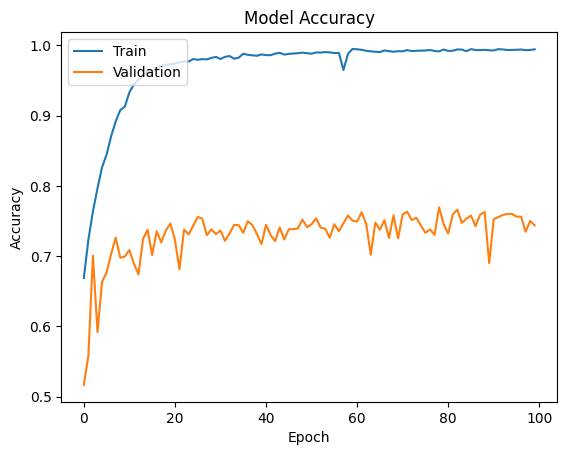

In [ ]:
# 정확도 그래프
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

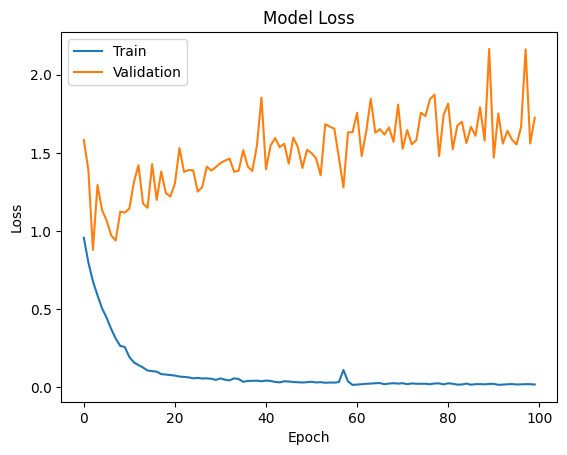

In [ ]:
# 손실 그래프
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
